# ​Sentiment Analysis and Rating Prediction of Movie Reviews

- Darlene Adams

### Import Libraries

In [1]:
## Import necessary packages
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import matplotlib as mpl
import seaborn as sns
import numpy as np
import re

# Increase column width
pd.set_option('display.max_colwidth', 250)

### Custom Function

In [2]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):

    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue


            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts

### Load the Data

In [3]:
df = pd.read_csv('Data/movie_reviews_v2.csv')
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0


In [4]:
# number of reviews
df.shape

(8650, 6)

In [5]:
df['rating'].value_counts()

7.0     1576
6.0     1386
8.0     1259
5.0      732
9.0      616
10.0     564
4.0      514
1.0      284
3.0      254
2.0      153
7.5       27
8.5       23
6.5       22
9.5       15
0.5       10
5.5        6
3.5        4
4.5        4
1.5        3
2.5        2
Name: rating, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

## Creating Groups for Classification

In [9]:
# Checking what values are in the overall ratings
df['rating'].value_counts()

7.0     1576
6.0     1386
8.0     1259
5.0      732
9.0      616
10.0     564
4.0      514
1.0      284
3.0      254
2.0      153
7.5       27
8.5       23
6.5       22
9.5       15
0.5       10
5.5        6
3.5        4
4.5        4
1.5        3
2.5        2
Name: rating, dtype: int64

In [10]:
def create_groups(x):
    if x >=9:
        return "high"
    elif x <=4:
        return "low"
    else:
        return None

In [11]:
# Should return high
create_groups(6.0)

In [12]:
# Should return high
create_groups(3.0)

'low'

In [13]:
# Should return high
create_groups(9.0)

'high'

In [14]:
## Use the function to create a new "rating" column with groups
df['ratings'] = df['rating'].map(create_groups)
df['ratings'].value_counts(dropna=False)

None    6231
low     1224
high    1195
Name: ratings, dtype: int64

In [15]:
## Check class balance of 'rating'
df['ratings'].value_counts(normalize=True)

low     0.505994
high    0.494006
Name: ratings, dtype: float64

In [16]:
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,ratings
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,high
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None


In [17]:
# normalizing to all lower case
df['lower'] = df['review'].str.lower()
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife,..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,high,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima..."


In [18]:
# NLTK's Tweet Tokenization
tweet_tokenizer = TweetTokenizer()
df['tokens'] = df['lower'].fillna('').apply(lambda x: tweet_tokenizer.tokenize(x))
df['tokens'].head(5)

0    [this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, ...
1    [a, guilty, pleasure, for, me, personally, ,, as, i, love, both, ', the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, bot...
2    [made, my, roommate, who, hates, stop-motion, animation, watched, this, in, 2018, and, even, he, had, a, good, time, ., it's, maybe, not, as, great, as, i, remember, thinking, it, was, when, i, was, a, little, kid, ,, but, it, still, holds, up, t...
3    [a, very, good, stop-motion, animation, !, <em>, ', chicken, run, ', </em>, ,, which, i, watched, a, crap, tonne, when, i, was, little, but, not, for, a, vast, number, of, years, now, ,, is, an, impressive, production, given, it, 

In [19]:
import spacy
# Disable parser and ner
nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])
# Print active components
nlp_light.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [20]:
#defining the spacy processing function
def spacy(text):
        """Lemmatize tokens, lower case, remove punctuation, spaces, and stop words"""
        doc = nlp_light(text)
        processed_doc = [token.lemma_ for token in doc if not token.is_punct and
                         not token.is_space and not token.is_stop and
                         not 'http' in token.lemma_ and 'www' not in token.lemma_]
        return processed_doc

In [21]:
# Join the lists of tokens into strings
df['tokens_as_strings'] = df['tokens'].apply(lambda x: ' , '.join(x))

#### Remove non-alphnumeric characters found in the first submission

In [22]:
df['clean'] = df['tokens_as_strings'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower,tokens,tokens_as_strings,clean
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife,...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, ...","this , is , a , fine , piece , of , cinema , from , wong , kar-wai , that , tells , us , a , story , of , two , people , whom , circumstance , throws , together , - , but , not , in , a , way , you , might , expect , . , we , start , with , two ,...",this is a fine piece of cinema from wong karwai that tells us a story of two people whom circumstance throws together but not in a way you might expect we start with two couples who move into a new buil...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,high,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, ', the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, bot...","a , guilty , pleasure , for , me , personally , , , as , i , love , both , ' , the , great , escape , ' , and , most , of , the , works , i , have , seen , , , over , the , years , , , from , this , rightfully-esteemed , british , animation , com...",a guilty pleasure for me personally as i love both the great escape and most of the works i have seen over the years from this rightfullyesteemed british animation company highly recommended both for ...


In [23]:
# Join the lists of tokens into strings
df['lemmas'] = df['clean'].apply(spacy)

In [24]:
# Join list of lemmas into a string with spaces between each token
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower,tokens,tokens_as_strings,clean,lemmas,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife,...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, ...","this , is , a , fine , piece , of , cinema , from , wong , kar-wai , that , tells , us , a , story , of , two , people , whom , circumstance , throws , together , - , but , not , in , a , way , you , might , expect , . , we , start , with , two ,...",this is a fine piece of cinema from wong karwai that tells us a story of two people whom circumstance throws together but not in a way you might expect we start with two couples who move into a new buil...,"[fine, piece, cinema, wong, karwai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end...",fine piece cinema wong karwai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end not long friendship develop us...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,high,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, ', the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, bot...","a , guilty , pleasure , for , me , personally , , , as , i , love , both , ' , the , great , escape , ' , and , most , of , the , works , i , have , seen , , , over , the , years , , , from , this , rightfully-esteemed , british , animation , com...",a guilty pleasure for me personally as i love both the great escape and most of the works i have seen over the years from this rightfullyesteemed british animation company highly recommended both for ...,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfullyesteemed, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfullyesteemed british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. it's maybe not as great as i remember thinking it was when i was a little kid, but it still hold

In [25]:
# making a tweet token joined string column
df['tokens_joined'] = df['tokens'].map(lambda x: " ".join(x))
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,ratings,lower,tokens,tokens_as_strings,clean,lemmas,lemmas-joined,tokens_joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. we start with two couples who move into a new building. one a newspaper man with his wife,...","[this, is, a, fine, piece, of, cinema, from, wong, kar-wai, that, tells, us, a, story, of, two, people, whom, circumstance, throws, together, -, but, not, in, a, way, you, might, expect, ., we, start, with, two, couples, who, move, into, a, new, ...","this , is , a , fine , piece , of , cinema , from , wong , kar-wai , that , tells , us , a , story , of , two , people , whom , circumstance , throws , together , - , but , not , in , a , way , you , might , expect , . , we , start , with , two ,...",this is a fine piece of cinema from wong karwai that tells us a story of two people whom circumstance throws together but not in a way you might expect we start with two couples who move into a new buil...,"[fine, piece, cinema, wong, karwai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, end...",fine piece cinema wong karwai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end not long friendship develop us...,this is a fine piece of cinema from wong kar-wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect . we start with two couples who move into a new building . one a newspaper man with his wif...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,high,"a guilty pleasure for me personally, as i love both 'the great escape' and most of the works i have seen, over the years, from this rightfully-esteemed british animation company. highly recommended both for children and for adults who enjoy anima...","[a, guilty, pleasure, for, me, personally, ,, as, i, love, both, ', the, great, escape, ', and, most, of, the, works, i, have, seen, ,, over, the, years, ,, from, this, rightfully-esteemed, british, animation, company, ., highly, recommended, bot...","a , guilty , pleasure , for , me , personally , , , as , i , love , both , ' , the , great , escape , ' , and , most , of , the , works , i , have , seen , , , over , the , years , , , from , this , rightfully-esteemed , british , animation , com...",a guilty pleasure for me personally as i love both the great escape and most of the works i have seen over the years from this rightfullyesteemed british animation company highly recommended both for ...,"[guilty, pleasure, personally, love, great, escape, work, see, year, rightfullyesteemed, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape work see year rightfullyesteemed british animation company highly recommend child adult enjoy animation,"a guilty pleasure for me personally , as i love both ' the great escape ' and most of the works i have seen , over the years , from this rightfully-esteemed british animation company . highly recommended both for children and for adults who enjoy

In [26]:
# # Save the processed data
import joblib
fpath = 'Data/movie_reviews.joblib'
joblib.dump(df, fpath, compress=9)

['Data/movie_reviews.joblib']

In [27]:
# filters
filter_high = df['ratings'] == 'high'
filter_low = df['ratings'] == 'low'
filter_high.sum(), filter_low.sum()

(1195, 1224)

In [28]:

## Create a new column of the lengths of each review
df['length']= df['review'].map(len)

In [29]:
## Analyze the statistics of the lengths
df['length'].describe()

count     8650.000000
mean      1354.578150
std       1836.029414
min          1.000000
25%        321.000000
50%        897.000000
75%       1661.000000
max      25841.000000
Name: length, dtype: float64

In [30]:
# Define a function to count words in a text
def word_count(tokens):
    return len(tokens)

# Apply the word_count function to the filtered data
word_count_high = df.loc[filter_high, 'tokens'].apply(word_count)
word_count_low = df.loc[filter_low, 'tokens'].apply(word_count)

# Display the results
print(f"The average word count for high reviews: {word_count_high.mean()}")
print(f"The average word count for low reviews: {word_count_low.mean()}")

The average word count for high reviews: 291.26694560669455
The average word count for low reviews: 238.76225490196077


## EDA and Visualization:

In [31]:
from wordcloud import WordCloud, STOPWORDS

In [32]:
# Make a single giant string with entire group of Real news lemmas
high_lemmas = " ".join( df.loc[filter_high, 'clean'])
# Make a single giant string with entire group of 1 star lemmas
low_lemmas= " ".join( df.loc[filter_low, 'clean'])

In [33]:
# addings custom stopwords high in both high and low ratings
stops = [*STOPWORDS, 'film', 'movie', 'watch', 'bad', 'good', 'time', 'story',
        'way', 'character', 'know','feel','go','think','see','come','people',
        'work','end','scene','thing']

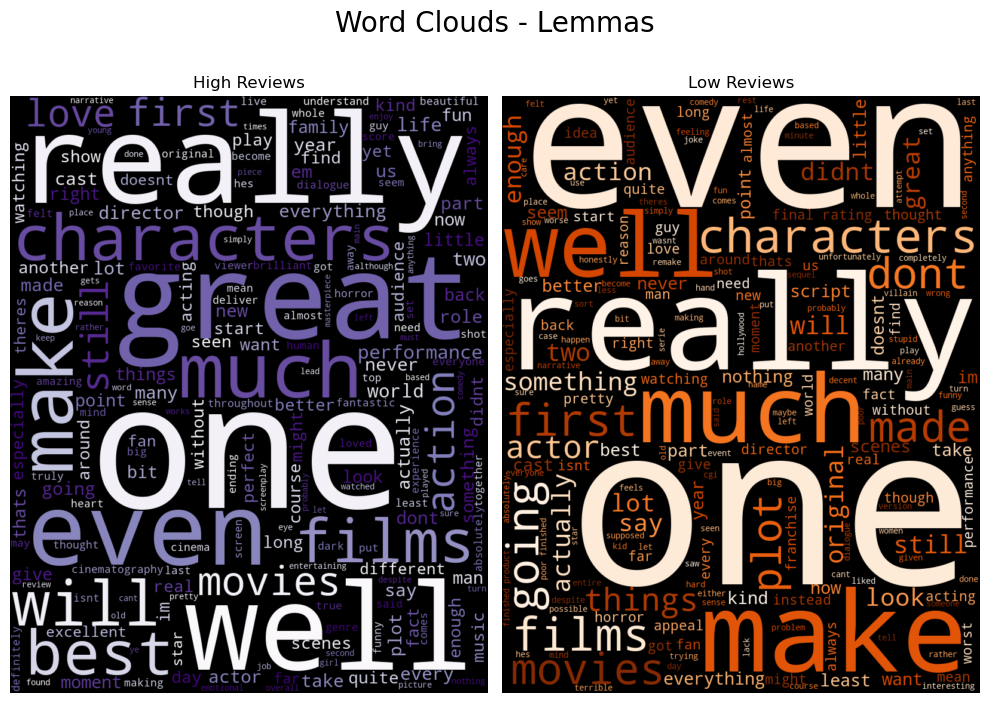

In [34]:
# Make word clouds of lemmas
# Create an instance of a WordCloud and use the generate method
high_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Purples",
                      stopwords=stops
                     ).generate(high_lemmas)
low_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Oranges",
                       stopwords=stops
                      ).generate(low_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(high_cloud, interpolation='bilinear')
axes[0].set_title("High Reviews")
axes[1].imshow(low_cloud, interpolation='bilinear')
axes[1].set_title("Low Reviews")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);

In [35]:
# Import Freqdist
from nltk.probability import FreqDist

In [36]:
# Create lists of all lemmas in both Fake and Real article groups
high_lemmas_list = df.loc[filter_high, 'lemmas'].explode().astype(str).to_list()
low_lemmas_list = df.loc[filter_low, 'lemmas'].explode().astype(str).to_list()


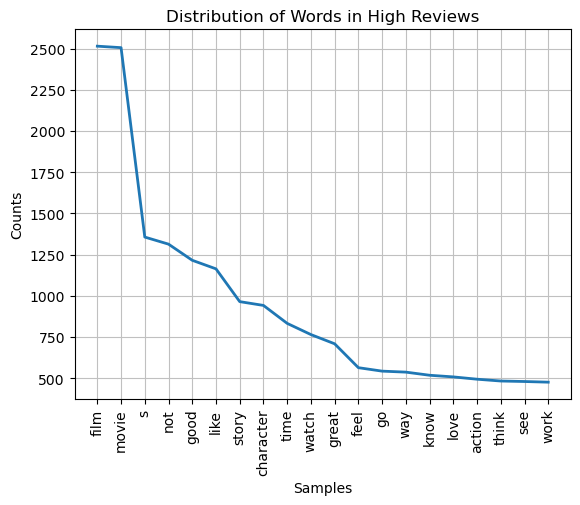

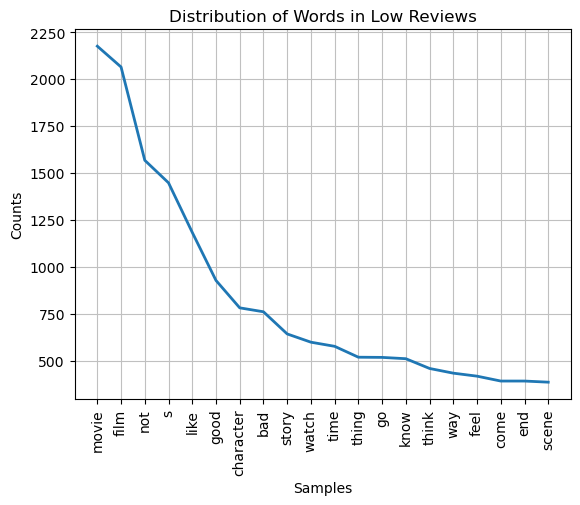

<Axes: title={'center': 'Distribution of Words in Low Reviews'}, xlabel='Samples', ylabel='Counts'>

In [37]:
# Plot distribution of words in REAL news
high_dist = FreqDist(high_lemmas_list)
high_dist.plot(20, title='Distribution of Words in High Reviews')
# Plot distribution of words in FAKE news
low_dist = FreqDist(low_lemmas_list)
low_dist.plot(20, title='Distribution of Words in Low Reviews')

In [38]:
## Import the ngrams function
from nltk import ngrams

In [39]:
import nltk

# Instantiate a measures objects for Bigrams
bigrams = nltk.collocations.BigramAssocMeasures()

In [40]:
# finder/scores for high reviews
bigrams_high = nltk.BigramCollocationFinder.from_words(high_lemmas_list)
bi_scores_high = bigrams_high.score_ngrams(bigrams.raw_freq)
bi_scores_high[:10]

[(('ve', 'see'), 0.0007991174349037523),
 (('feel', 'like'), 0.0007920455991966395),
 (('good', 'movie'), 0.0007071835707112852),
 (('watch', 'movie'), 0.0006081778708117053),
 (('not', 'know'), 0.0005445313494476897),
 (('good', 'film'), 0.0005303876780334639),
 (('don', 't'), 0.00048088482808367395),
 (('will', 'not'), 0.0004455256495481097),
 (('movie', 'like'), 0.00043845381384099687),
 (('special', 'effect'), 0.000431381978133884)]

In [41]:
# finder/scores for high reviews
bigrams_low = nltk.BigramCollocationFinder.from_words(low_lemmas_list)
bi_scores_low = bigrams_low.score_ngrams(bigrams.raw_freq)
bi_scores_low[:10]

[(('final', 'rating'), 0.0016201449512663847),
 (('feel', 'like'), 0.001128930790510087),
 (('not', 'know'), 0.0009738105292186247),
 (('finish', 'product'), 0.0008273080602211326),
 (('look', 'like'), 0.0008273080602211326),
 (('appeal', 'poor'), 0.0008186902679271624),
 (('poor', 'finish'), 0.0008186902679271624),
 (('rating', 'thing'), 0.0008186902679271624),
 (('thing', 'appeal'), 0.0008186902679271624),
 (('doesn', 't'), 0.0007066589681055507)]

In [42]:
# Convert list of tuples to dataframe for high
df_bi_scores_high = pd.DataFrame(bi_scores_high, columns=['Words','Frequency'])
df_bi_scores_high.head()

,Words,Frequency
0,"(ve, see)",0.000799
1,"(feel, like)",0.000792
2,"(good, movie)",0.000707
3,"(watch, movie)",0.000608
4,"(not, know)",0.000545


In [43]:
# Convert list of tuples to dataframe for low
df_bi_scores_low = pd.DataFrame(bi_scores_low, columns=['Words','Frequency'])
df_bi_scores_low.head()

,Words,Frequency
0,"(final, rating)",0.001620
1,"(feel, like)",0.001129
2,"(not, know)",0.000974
3,"(finish, product)",0.000827
4,"(look, like)",0.000827


In [44]:
# Combine low and high reviews score dfs and add a group name as multi-index
df_compare_bigrams = pd.concat(
    [df_bi_scores_high, df_bi_scores_low],
    axis=1,
    keys=["High Rating Reviews", "Low Rating Reviews"],
)
df_compare_bigrams.head()

High Rating Reviews           Low Rating Reviews          
                Words Frequency              Words Frequency
0           (ve, see)  0.000799    (final, rating)  0.001620
1        (feel, like)  0.000792       (feel, like)  0.001129
2       (good, movie)  0.000707        (not, know)  0.000974
3      (watch, movie)  0.000608  (finish, product)  0.000827
4         (not, know)  0.000545       (look, like)  0.000827

In [45]:
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder

    elif ngrams == 3:
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()


    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [46]:
get_ngram_measures_finder(high_lemmas_list, ngrams=3, top_n=20)

,Words,Raw Freq
0,"(enjoy, read, spoilerfree)",0.000163
1,"(read, spoilerfree, review)",0.000163
2,"(review, follow, blog)",0.000163
3,"(spoilerfree, review, follow)",0.000163
4,"(movie, ve, see)",0.000127
5,"(comic, book, movie)",0.000113
6,"(film, ve, see)",0.000099
7,"(href, rel, nofollow)",0.000099
8,"(star, war, movie)",0.000099
9,"(world, war, z)",0.000099


In [47]:
get_ngram_measures_finder(low_lemmas_list, ngrams=3, top_n=20)

,Words,Raw Freq
0,"(appeal, poor, finish)",0.000819
1,"(final, rating, thing)",0.000819
2,"(poor, finish, product)",0.000819
3,"(rating, thing, appeal)",0.000819
4,"(thing, appeal, poor)",0.000819
5,"(boring, disappointing, avoid)",0.000500
6,"(disappointing, avoid, possible)",0.000500
7,"(final, rating, boring)",0.000500
8,"(rating, boring, disappointing)",0.000500
9,"(will, not, watch)",0.000276


In [48]:
md_table_bigrams = df_compare_bigrams.head(10).to_markdown(index=False)

### Observations Noted

People that take time to leave reviews often make sure they dont have spoilers. The low ratings seem to dislike the endings or find the movie boring, while positive reviews often praise the actors and set

Sentiment Analysis

In [49]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dmusl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
# instantiate sia
sia = SentimentIntensityAnalyzer()

In [51]:
# add sentiment scores column by mapping sia
df['scores'] = df['clean'].map(sia.polarity_scores)

# save as variable (series)
scores = df['scores'].apply(pd.Series)

# add columns to df
df = pd.concat([df, scores], axis=1).drop('scores', axis=1)

In [52]:
# Define filter for positive reviews
pos_sentiment_reviews = df['compound'] > 0
pos_sentiment_reviews.sum()

6650

In [53]:
# Identify reviews with a positive sentiment score that received 1 star
filter_mismatch_A = (df['ratings'] == 'low') & pos_sentiment_reviews
pos_sent_1_star = df.loc[filter_mismatch_A,['clean','ratings','compound']]
pos_sent_1_star.head(2)

,clean,ratings,compound
72,what a great cast for such a cheap film description three college students base their class project around gossip and how fast it spreads which soon spirals out of control review gossip is a dramatic t...,low,0.8573
87,some couples dance others go to mars it was the year of two mars based movies with the other being red planet of pitch black and the chaotic history that produced the supernova plenty of scifi around ...,low,0.8269


In [54]:
# Identify 5 star reviews with negative sentiment
filter_mismatch_B = (df['ratings'] == 'high') & ~pos_sentiment_reviews
df.loc[filter_mismatch_B,['clean','ratings','compound']].head(2)

,clean,ratings,compound
22,one of those few movies that most people dont care for but i personally think is criminally underrated final rating ridiculously strong appeal i can t stop thinking about it,high,-0.3391
59,dazzling bjrk in this indictment against the death sentence in tight closeups this film is a ufo musical without being,high,-0.5574


Observations

low ratings that have positive sentiment often refer to the cast performance as well as the plot. High ratings with low scores often use the negative words in a positive way and unfortunately the model cant pick it up

If you want a high rated movie
- have great actors
- solid and original plot
- great set or cinematography

Avoid
- slow moving plots
- incomplete or poor endings
- diverging from the original book or movie if based on one.